# Import libraries

In [ ]:
import requests
import nltk
import spacy
import tensorflow as tf
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
from tensorflow.keras import utils

# Load data

In [2]:
import requests
import os

# 10.5281/zenodo.17054610
record_id = '17054610'
filename_to_download = 'vk_groups_dataset.xlsx'

api_url = f'https://zenodo.org/api/records/{record_id}'

try:
    print(f"Searching for file '{filename_to_download}' in Zenodo repository with ID: {record_id}...")

    response = requests.get(api_url)
    response.raise_for_status()
    data = response.json()

    file_url = None
    for file in data.get('files', []):
        if file.get('key') == filename_to_download:
            file_url = file.get('links', {}).get('self')
            break

    if file_url:
        print(f"File '{filename_to_download}' found. Starting download...")

        file_response = requests.get(file_url, stream=True)
        file_response.raise_for_status()

        # Save the file to the current directory
        with open(filename_to_download, 'wb') as f:
            for chunk in file_response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"File '{filename_to_download}' downloaded successfully.")
    else:
        print(f"File '{filename_to_download}' not found in the repository.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred while accessing Zenodo: {e}")


groups = pd.read_excel('vk_groups_dataset.xlsx')
groups = groups.dropna()

groups = groups.rename(columns={
    'ID_группы': 'Group_ID',
    'Название': 'Title',
    'ID_города': 'City_ID',
    'Город': 'City',
    'Описание': 'Description',
    'Признак': 'Feature'
})

groups

Searching for file 'vk_groups_dataset.xlsx' in Zenodo repository with ID: 17054610...
File 'vk_groups_dataset.xlsx' found. Starting download...
File 'vk_groups_dataset.xlsx' downloaded successfully.


,Group_ID,Title,City_ID,City,Description,Feature
0,177967802,"Мемы, просто мемы©",73.0,Красноярск,Только мемы,0
1,164044699,Дон Корлеоне | Доставка еды в Донецке,8590.0,Донецк,"Доставка вкусных суши, пиццы и роллов в Донецке.",1
2,94593777,Книги Ольги Гучковой - фэнтези,108.0,Орск,Авторская группа писателя Гучковой Ольги. \nВс...,0
3,228450292,ДОСТАВКА ДОМАШНИХ ОБЕДОВ | ПАПА РЯДОМ |,58.0,Ишим,"Мы предоставляем услуги доставки домашней еды,...",1
4,168035552,Додо Пицца Елабуга,50.0,Елабуга,"«Додо Пицца» — международная сеть, которая род...",1
...,...,...,...,...,...,...
11604,210695374,Мемы,55.0,Иваново,Мемы,0
11606,202979643,Sushi Shik | Алчевск | Роллы,5648.0,Алчевск,БЕСПЛАТНАЯ ДОСТАВКА от 1500р\n\nОформляйте зак...,1
11610,228814825,Доставка Kaifa | суши роллы Излучинск,2162.0,Излучинск,"🔹Отправь ""+"" в сообщения и забирай подарок!🔹\n...",1
11611,58188402,Доставка обедов СПБ | Кулинария | Торты,2.0,Санкт-Петербург,"Организация питания групп, обеды в офисе, кейт...",1


# Dividing the data into training and test sets

In [3]:
# auxiliary function of dividing dataframes
def split_dataframe(dataframe, test_proportion):
    total_size = len(dataframe)
    test_size = int(total_size * test_proportion)
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    train_indices = indices[0:total_size-test_size]
    test_indices = indices[total_size - test_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]

In [4]:
train, test = split_dataframe(groups, 0.3)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

We highlight the correct answers




In [5]:
nb_classes = 2
y_train = utils.to_categorical(train["Feature"], nb_classes)

y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

# Tokenization of text

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils


In [7]:
# number of tokenizer words
num_words = 100000

tokenizer = Tokenizer(num_words=num_words)
names = train['Title']
descrs = train['Description']

names

,Title
0,Суши SELL Гатчина
1,Геймерский Юмор
2,Фотография
3,Творческая фотография Виталия Монахова | Бологое
4,"Суши Ам (Стародуб, Погар)"
...,...
5808,Морские книги
5809,Пенза Live Новости
5810,Суши Мастер Ярославль
5811,Суши Wok Ижевск


In [8]:
tokenizer.fit_on_texts(descrs)
tokenizer.word_index

{'и': 1,
 'в': 2,
 'с': 3,
 'на': 4,
 '00': 5,
 'доставка': 6,
 'по': 7,
 'для': 8,
 'от': 9,
 'мы': 10,
 'до': 11,
 'https': 12,
 'не': 13,
 'вы': 14,
 'суши': 15,
 'это': 16,
 'или': 17,
 'vk': 18,
 '—': 19,
 '10': 20,
 'а': 21,
 'к': 22,
 'ru': 23,
 'роллы': 24,
 'вас': 25,
 'у': 26,
 'заказ': 27,
 'доставки': 28,
 'com': 29,
 'из': 30,
 'что': 31,
 '–': 32,
 'за': 33,
 'только': 34,
 'нас': 35,
 '•': 36,
 'вам': 37,
 '8': 38,
 '11': 39,
 '7': 40,
 'ул': 41,
 'пицца': 42,
 'все': 43,
 '22': 44,
 'еды': 45,
 'меню': 46,
 'работы': 47,
 '1': 48,
 'бесплатная': 49,
 'при': 50,
 'рублей': 51,
 'заказа': 52,
 'заказать': 53,
 'о': 54,
 'блюда': 55,
 'можно': 56,
 'еда': 57,
 'день': 58,
 '30': 59,
 '23': 60,
 'г': 61,
 'руб': 62,
 'время': 63,
 'как': 64,
 'мемы': 65,
 '✧': 66,
 'роллов': 67,
 '2': 68,
 'чтобы': 69,
 'каждый': 70,
 'так': 71,
 'заказы': 72,
 'наш': 73,
 'заказе': 74,
 'cc': 75,
 'можете': 76,
 'если': 77,
 'блюд': 78,
 'здесь': 79,
 'новости': 80,
 '3': 81,
 'книги': 82,

# Converting descriptions to numeric representation

In [9]:
sequences = tokenizer.texts_to_sequences(descrs)

index = 15
print(descrs[index])
print(sequences[index])

Здесь будут мемы придуманные мной)))
Д.р.группы: 13 апреля
[79, 395, 65, 12751, 161, 111, 192, 121, 333, 12752]


In [10]:
#determining the max length
max = 0
for i in sequences:
  if len(i) > max: max = len(i)
max

560

In [11]:
sequences

[[12,
  18,
  29,
  315,
  19315,
  594,
  19316,
  211,
  19317,
  424,
  48,
  79,
  313,
  4,
  747,
  187,
  33,
  804,
  22,
  239,
  178,
  279,
  697,
  179,
  878,
  998,
  86,
  10,
  224,
  879,
  4,
  999,
  1000,
  26,
  1001,
  843,
  362,
  891,
  19,
  16,
  913,
  87,
  24,
  8,
  275,
  253,
  226,
  107,
  256,
  283,
  761,
  976,
  595,
  1,
  953,
  805,
  219,
  430,
  169,
  6,
  659,
  22,
  730,
  69,
  645,
  1002,
  2,
  954,
  931,
  120,
  115,
  59,
  158,
  208,
  507,
  52,
  26,
  35,
  33,
  1003,
  955,
  528,
  2,
  20,
  142,
  447,
  1032,
  977,
  3,
  777,
  978,
  280,
  979,
  105,
  1,
  1138,
  698,
  441,
  1190,
  367,
  12,
  1004,
  1005,
  23,
  345,
  668,
  219,
  806,
  1,
  807,
  2,
  932,
  356,
  19,
  551,
  639,
  616,
  1,
  1225,
  219,
  12,
  18,
  75,
  19318,
  79,
  14,
  76,
  439,
  87,
  577,
  9,
  35,
  367,
  12,
  180,
  132,
  19319,
  2618,
  6557,
  12738],
 [231, 892, 80, 2743, 9731],
 [14,
  19320,
  143,
  51

We reduce the length of the names to one value

In [12]:
x_train = pad_sequences(sequences, maxlen = max)
x_train

array([[    0,     0,     0, ...,  2618,  6557, 12738],
       [    0,     0,     0, ...,    80,  2743,  9731],
       [    0,     0,     0, ...,   825,     4, 19324],
       ...,
       [    0,     0,     0, ...,     1,     3,  1356],
       [    0,     0,     0, ...,   613,   181,  1117],
       [    0,     0,     0, ...,  1010,   469,  2076]], dtype=int32)

# Convolutional neural network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
model_cnn = Sequential()
model_cnn.add(Embedding(100, 32, input_length=max))
model_cnn.add(Conv1D(350, 8, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Creating Callback

In [15]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=15,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6790 - loss: 0.5839
Epoch 1: val_accuracy improved from -inf to 0.92440, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6814 - loss: 0.5810 - val_accuracy: 0.9244 - val_loss: 0.2466
Epoch 2/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9281 - loss: 0.2247
Epoch 2: val_accuracy improved from 0.92440 to 0.93986, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9283 - loss: 0.2238 - val_accuracy: 0.9399 - val_loss: 0.1872
Epoch 3/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9384 - loss: 0.1792
Epoch 3: val_accuracy did not improve from 0.93986
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9383 - loss: 0.1793 - val_accuracy: 0.9381 - val_loss: 0.2173
Epoch 4/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9405 - loss: 0.1686
Epoch 4: val_accuracy did not improve from 0.93986
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9406 - loss: 0.1685 - val_accuracy: 0.9244 - val_loss: 0.1832
Epoch 5/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9425 - loss: 0.1629
Epoch 5: val_accuracy improved from 0.93986 to 0.94674, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9426 - loss: 0.1626 - val_accuracy: 0.9467 - val_loss: 0.1610
Epoch 6/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9461 - loss: 0.1432
Epoch 6: val_accuracy did not improve from 0.94674
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9459 - loss: 0.1437 - val_accuracy: 0.8557 - val_loss: 0.2522
Epoch 7/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9186 - loss: 0.2006
Epoch 7: val_accuracy did not improve from 0.94674
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9191 - loss: 0.1996 - val_accuracy: 0.9313 - val_loss: 0.1732
Epoch 8/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9485 - loss: 0.1488
Epoch 8: val_accuracy did not improve from 0.94674
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9485 - loss: 0.1486 - val_accuracy: 0.9433 - val_loss: 0.1650
Epoch 9/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9562 - loss: 0.1173
Epoch 9: val_accuracy did not improve from 

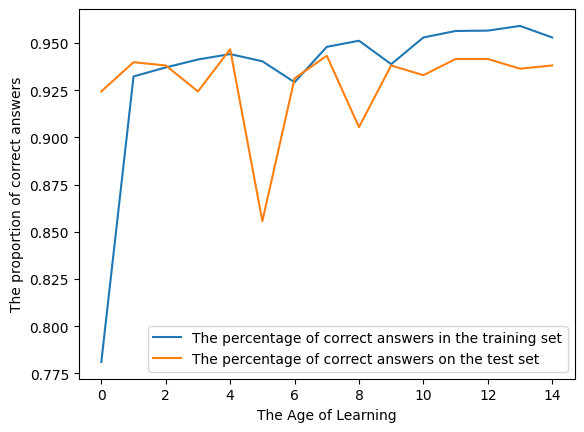

In [16]:
plt.plot(history_cnn.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_cnn.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Recurrent LSTM network

In [17]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(2, activation='softmax'))

model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6695 - loss: 0.6461
Epoch 1: val_accuracy improved from -inf to 0.76804, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6705 - loss: 0.6449 - val_accuracy: 0.7680 - val_loss: 0.4897
Epoch 2/5
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8622 - loss: 0.3579
Epoch 2: val_accuracy improved from 0.76804 to 0.94158, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8650 - loss: 0.3525 - val_accuracy: 0.9416 - val_loss: 0.1811
Epoch 3/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9633 - loss: 0.1376
Epoch 3: val_accuracy improved from 0.94158 to 0.97594, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9636 - loss: 0.1368 - val_accuracy: 0.9759 - val_loss: 0.1039
Epoch 4/5
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9849 - loss: 0.0707
Epoch 4: val_accuracy improved from 0.97594 to 0.98282, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9849 - loss: 0.0705 - val_accuracy: 0.9828 - val_loss: 0.0731
Epoch 5/5
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9937 - loss: 0.0413
Epoch 5: val_accuracy did not improve from 0.98282
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9936 - loss: 0.0413 - val_accuracy: 0.9708 - val_loss: 0.0937


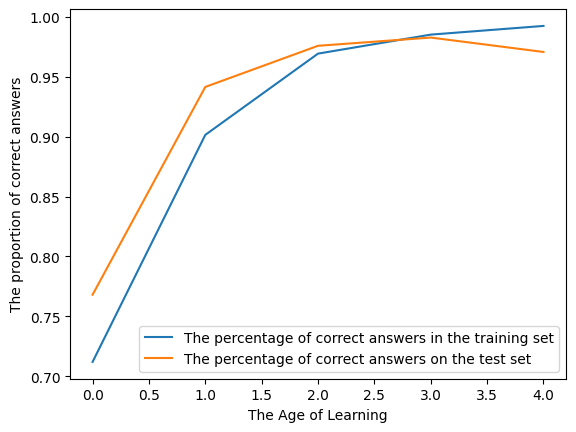

In [19]:
plt.plot(history_lstm.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_lstm.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Recurrent GRU network

In [20]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max))
model_gru.add(GRU(16))
model_gru.add(Dense(2, activation='softmax'))

model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5979 - loss: 0.6713
Epoch 1: val_accuracy improved from -inf to 0.68557, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5998 - loss: 0.6697 - val_accuracy: 0.6856 - val_loss: 0.5525
Epoch 2/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7775 - loss: 0.4524
Epoch 2: val_accuracy improved from 0.68557 to 0.91065, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7802 - loss: 0.4483 - val_accuracy: 0.9107 - val_loss: 0.2277
Epoch 3/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9510 - loss: 0.1464
Epoch 3: val_accuracy improved from 0.91065 to 0.95533, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9514 - loss: 0.1454 - val_accuracy: 0.9553 - val_loss: 0.1467
Epoch 4/5
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9788 - loss: 0.0718
Epoch 4: val_accuracy did not improve from 0.95533
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9789 - loss: 0.0714 - val_accuracy: 0.9536 - val_loss: 0.1256
Epoch 5/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9874 - loss: 0.0485
Epoch 5: val_accuracy improved from 0.95533 to 0.96564, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9875 - loss: 0.0481 - val_accuracy: 0.9656 - val_loss: 0.1018


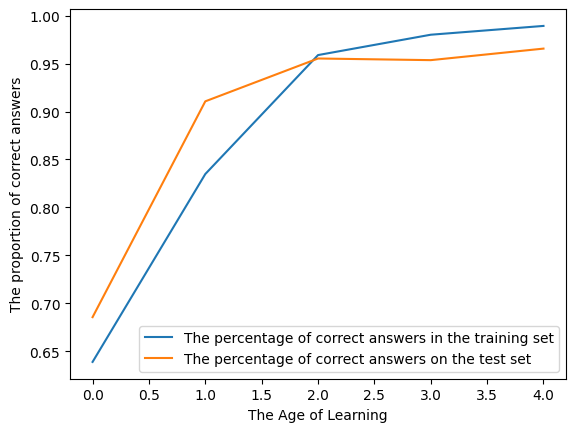

In [22]:
plt.plot(history_gru.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_gru.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Checking on the testing set

In [23]:
test

,Group_ID,Title,City_ID,City,Description,Feature
0,90459970,"Еда на заказ Одесса ""ПАТИССОН""",292.0,Одесса,НАДОЕЛО СТОЯТЬ У ПЛИТЫ?\nУ ТЕБЯ НЕТ ВРЕМЕНИ НА...,1
1,157307690,Мучкапские новости,5786.0,Мучкапский,"Официальная группа редакции районной газеты ""М...",0
2,80947588,ДМИТРИЙ ВАЛЕВИЧ|РЖЯ|ЮМОР|,110.0,Пермь,"Агент ""СВОЙ В АЛЬФЕ""\nТренер-преподователь АФК...",0
3,232214716,Плов & Мангал доставка еды Нефтекамск,243.0,Нефтекамск,Скоро открытие доставки кавказских и европейск...,1
4,22924066,Лада Спорт Сервис интернет магазин спорт запчаст,143.0,Тольятти,Лада Спорт Сервис — самое первое тюнинг (спорт...,0
...,...,...,...,...,...,...
2486,230561275,"Доставка еды ""Красная панда"" г.Десногорск",787.0,Десногорск,"АДРЕС 3-20 МАГАЗИН ПЯТЕРОЧКА ""ОВОЩНОЙ""\nТЕЛЕФО...",1
2487,93207254,СВАДЕБНАЯ ФОТОГРАФИЯ,2.0,Санкт-Петербург,EMANUELE CARPENZANO - известный итальянский фо...,0
2488,231954680,Читайте книги,2.0,Санкт-Петербург,Здесь можно найти подходящую книгу для постоян...,0
2489,229108786,Суши Эра Первомайск | Доставка роллов,14727.0,Первомайск,👉 [https://vk.com/app5898182_-229108786?ref=gr...,1


In [24]:
test_sequences = tokenizer.texts_to_sequences(test['Description'])
x_test = pad_sequences(test_sequences, maxlen=max)
x_test

array([[    0,     0,     0, ..., 16905,  1226, 30138],
       [    0,     0,     0, ...,     1, 10688,   549],
       [    0,     0,     0, ...,  9810,  2943, 12447],
       ...,
       [    0,     0,     0, ...,  8443,   250,  2229],
       [    0,     0,     0, ...,   127,    83,   161],
       [    0,     0,     0, ...,  1392,   262,  1065]], dtype=int32)

In [25]:
y_test = utils.to_categorical(test['Feature'], nb_classes)
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

# We evaluate the quality of the networks on the test set

One-dimensional convolutional network

In [26]:
model_cnn.load_weights(model_cnn_save_path)
model_cnn.evaluate(x_test, y_test, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9357 - loss: 0.1742


[0.16571925580501556, 0.9381774663925171]

Recurrent LSTM Network

In [27]:
model_lstm.load_weights(model_lstm_save_path)
model_lstm.evaluate(x_test, y_test, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9702 - loss: 0.0982


[0.09203056246042252, 0.9731031656265259]

The GRU Recurrent Network

In [28]:
model_gru.load_weights(model_gru_save_path)
model_gru.evaluate(x_test, y_test, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9525 - loss: 0.1438


[0.12856003642082214, 0.957446813583374]